In [10]:
import stim
import numpy as np
import pymatching

In [11]:
import stim

def build_surface_code_circuit(qubit_coords, rounds=5, lookback_distance=1):
    """
    指定された量子ビットの座標を使用して、表面コードの回路を構築し、
    測定の後にディテクターを追加します。シンドローム測定は MR を使用します。
    最初のアンシラ量子ビットのリセットは残します。SHIFT_COORDS を追加して、
    ディテクターの座標を時間方向にシフトします。

    Parameters:
    - qubit_coords: 量子ビットの座標とインデックスの辞書 {(x, y): qubit_index}
    - rounds: スタビライザー測定の繰り返し回数（デフォルトは5）
    - lookback_distance: ディテクターが見る測定結果の距離（デフォルトは1）

    Returns:
    - circuit: 構築された stim.Circuit オブジェクト
    """
    circuit = stim.Circuit()

    # データ量子ビットと補助量子ビットの分類
    data_qubits = {}
    ancilla_qubits = {}
    qubit_indices = {}

    for (x, y), qubit in qubit_coords.items():
        qubit_indices[qubit] = (x, y)
        if qubit <= 8:
            data_qubits[(x, y)] = qubit
        else:
            ancilla_qubits[(x, y)] = qubit
    
    # QUBIT_COORDS を回路に追加
    for qubit, (x, y) in qubit_indices.items():
        circuit.append("QUBIT_COORDS", [qubit], [x, y])

    # データ量子ビットとアンシラ量子ビットの初期化
    circuit.append("R", list(data_qubits.values()))
    circuit.append("R", list(ancilla_qubits.values()))  # 最初のアンシラ量子ビットのリセット
    circuit.append("TICK")  # Reset の後に TICK

    num_ancilla = len(ancilla_qubits)  # アンシラ量子ビットの数
    total_measurements = 0  # 累積測定数の初期化

    # スタビライザー測定のラウンド
    for round_num in range(rounds):
        # MR を使用するため、ラウンド開始時のリセット操作は不要

        # X スタビライザーの補助量子ビットに H を適用
        x_ancillas = []
        for (x, y), ancilla in ancilla_qubits.items():
            if (x + y) % 4 != 0:
                x_ancillas.append(ancilla)
        x_ancillas = sorted(x_ancillas)
        circuit.append("H", x_ancillas)
        circuit.append("TICK")  # H の後に TICK

        # X と Z スタビライザーの CNOT ゲートを収集
        x_cnot_ops = [[] for _ in range(4)]
        z_cnot_ops = [[] for _ in range(4)]

        # X スタビライザーの CNOT (制御: 補助, ターゲット: データ)
        for ancilla in x_ancillas:
            x_pos, y_pos = qubit_indices[ancilla]
            for idx, (dx, dy) in enumerate([(1, 1), (-1, 1), (1, -1), (-1, -1)]):
                nx, ny = x_pos + dx, y_pos + dy
                if (nx, ny) in data_qubits:
                    data = data_qubits[(nx, ny)]
                    x_cnot_ops[idx].append((ancilla, data))

        # Z スタビライザーの CNOT (制御: データ, ターゲット: 補助)
        z_ancillas = []
        for (x, y), ancilla in ancilla_qubits.items():
            if (x + y) % 4 == 0:
                z_ancillas.append(ancilla)
        z_ancillas = sorted(z_ancillas)
        for ancilla in z_ancillas:
            x_pos, y_pos = qubit_indices[ancilla]
            for idx, (dx, dy) in enumerate([(1, 1), (1, -1), (-1, 1), (-1, -1)]):
                nx, ny = x_pos + dx, y_pos + dy
                if (nx, ny) in data_qubits:
                    data = data_qubits[(nx, ny)]
                    z_cnot_ops[idx].append((data, ancilla))

        # X と Z スタビライザーの CNOT を同時に追加し、4tick で終了するようにする
        for idx in range(4):
            combined_cnot_ops = x_cnot_ops[idx] + z_cnot_ops[idx]
            if combined_cnot_ops:
                controls, targets = zip(*combined_cnot_ops)
                cnot_targets = [q for pair in zip(controls, targets) for q in pair]
                circuit.append("CNOT", cnot_targets)
                circuit.append("TICK")  # CNOT の後に TICK

        # X スタビライザーの補助量子ビットに H を適用
        circuit.append("H", x_ancillas)
        circuit.append("TICK")  # H の後に TICK

        # すべての補助量子ビットを MR で測定
        sorted_ancillas = sorted(ancilla_qubits.values())
        circuit.append("MR", sorted_ancillas)
        circuit.append("TICK")  # 測定の後に TICK

        # 累積測定数を更新
        total_measurements += num_ancilla

        # ディテクターを追加
        for i, ancilla in enumerate(sorted_ancillas):
            x_pos, y_pos = qubit_indices[ancilla]

            # 現在の測定結果へのルックバックインデックス
            current_lookback = i - num_ancilla  # = -(num_ancilla - i)
            lookbacks = [stim.target_rec(current_lookback)]

            # 過去 a 個前までの測定結果を追加
            if round_num > 0:
                for j in range(1, lookback_distance + 1):
                    if round_num >= j:
                        prev_lookback = i - (j + 1) * num_ancilla  # = -(j + 1) * num_ancilla - i
                        lookbacks.append(stim.target_rec(prev_lookback))

                circuit.append(
                    "DETECTOR",
                    lookbacks,
                    [x_pos, y_pos, 0]
                )
            else:
                if (x_pos+y_pos)%4 == 0:
                    # 最初のラウンドでは、測定結果のみを使用
                    circuit.append(
                        "DETECTOR",
                        [stim.target_rec(current_lookback)],
                        [x_pos, y_pos, 0]
                    )
        circuit.append("SHIFT_COORDS", [], (0, 0, 1))

    # データ量子ビットの最終測定
    circuit.append("M", list(data_qubits.values()))
    circuit.append("TICK")  # 測定の後に TICK
    
    #

    return circuit

# メインプログラム
if __name__ == "__main__":
    # 提供された量子ビットの座標とインデックス
    qubit_coords = {
        (1,1): 0,
        (3,1): 1,
        (5,1): 2,
        (1,3): 3,
        (3,3): 4,
        (5,3): 5,
        (1,5): 6,
        (3,5): 7,
        (5,5): 8,
        (2,0): 9,
        (2,2): 10,
        (4,2): 11,
        (6,2): 12,
        (0,4): 13,
        (2,4): 14,
        (4,4): 15,
        (4,6): 16
    }

    # 回路の構築
    circuit = build_surface_code_circuit(qubit_coords, rounds=6, lookback_distance=1)

    # 回路の出力
    print(circuit)

QUBIT_COORDS(1, 1) 0
QUBIT_COORDS(3, 1) 1
QUBIT_COORDS(5, 1) 2
QUBIT_COORDS(1, 3) 3
QUBIT_COORDS(3, 3) 4
QUBIT_COORDS(5, 3) 5
QUBIT_COORDS(1, 5) 6
QUBIT_COORDS(3, 5) 7
QUBIT_COORDS(5, 5) 8
QUBIT_COORDS(2, 0) 9
QUBIT_COORDS(2, 2) 10
QUBIT_COORDS(4, 2) 11
QUBIT_COORDS(6, 2) 12
QUBIT_COORDS(0, 4) 13
QUBIT_COORDS(2, 4) 14
QUBIT_COORDS(4, 4) 15
QUBIT_COORDS(4, 6) 16
R 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
TICK
H 9 11 14 16
TICK
CX 9 1 11 5 14 7 4 10 6 13 8 15
TICK
CX 9 0 11 4 14 6 1 10 3 13 5 15
TICK
CX 11 2 14 4 16 8 3 10 5 12 7 15
TICK
CX 11 1 14 3 16 7 0 10 2 12 4 15
TICK
H 9 11 14 16
TICK
MR 9 10 11 12 13 14 15 16
TICK
DETECTOR(2, 2, 0) rec[-7]
DETECTOR(6, 2, 0) rec[-5]
DETECTOR(0, 4, 0) rec[-4]
DETECTOR(4, 4, 0) rec[-2]
SHIFT_COORDS(0, 0, 1)
H 9 11 14 16
TICK
CX 9 1 11 5 14 7 4 10 6 13 8 15
TICK
CX 9 0 11 4 14 6 1 10 3 13 5 15
TICK
CX 11 2 14 4 16 8 3 10 5 12 7 15
TICK
CX 11 1 14 3 16 7 0 10 2 12 4 15
TICK
H 9 11 14 16
TICK
MR 9 10 11 12 13 14 15 16
TICK
DETECTOR(2, 0, 0) rec[-8] re

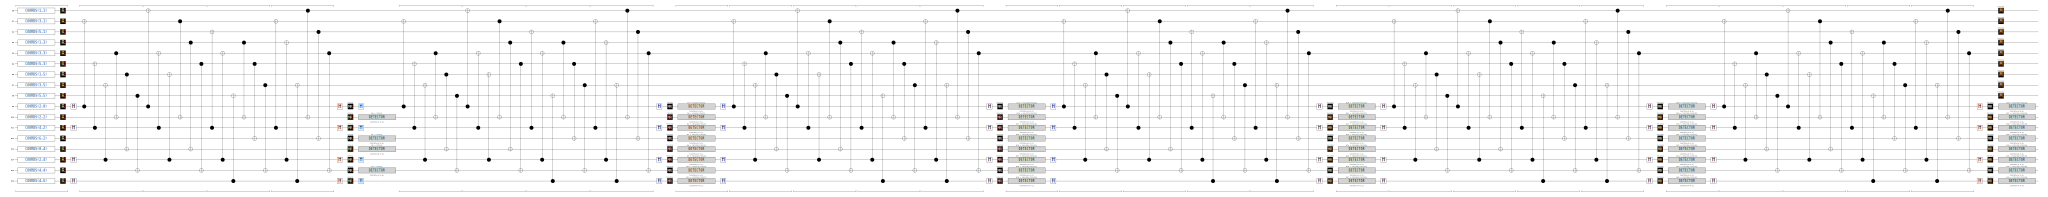

In [12]:
circuit.diagram('timeline-svg')

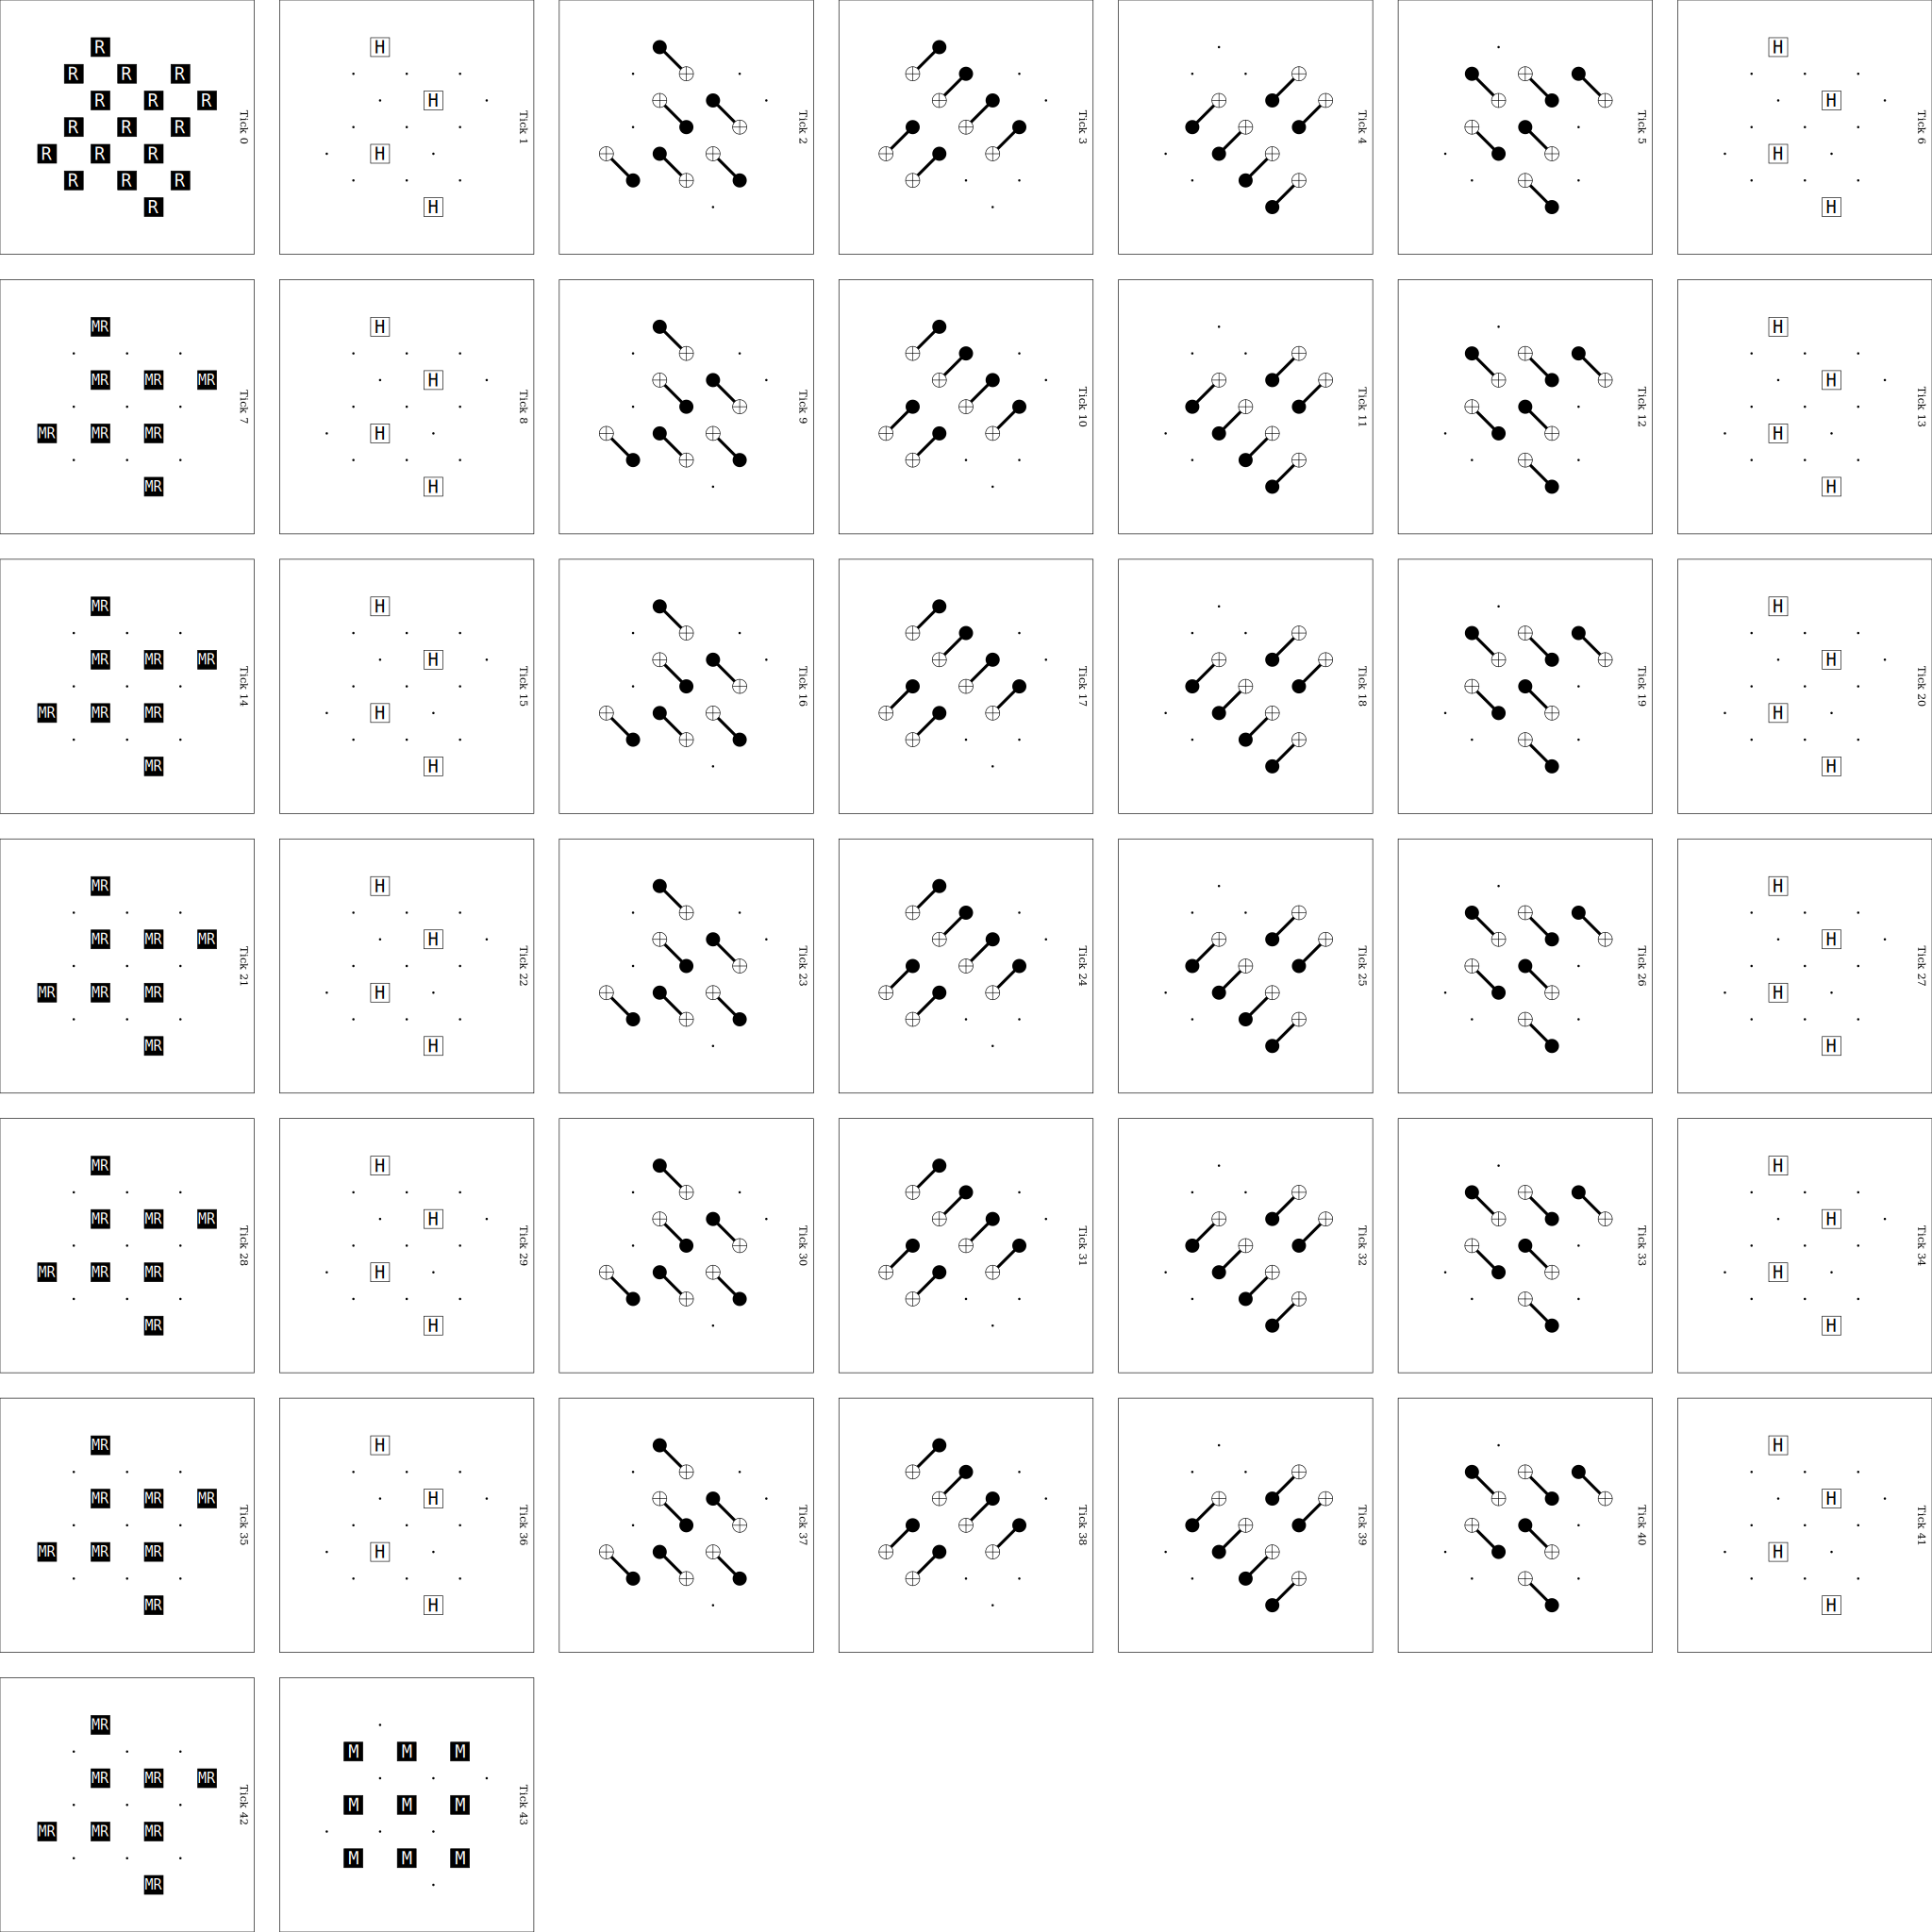

In [13]:
circuit.without_noise().diagram("timeslice-svg")

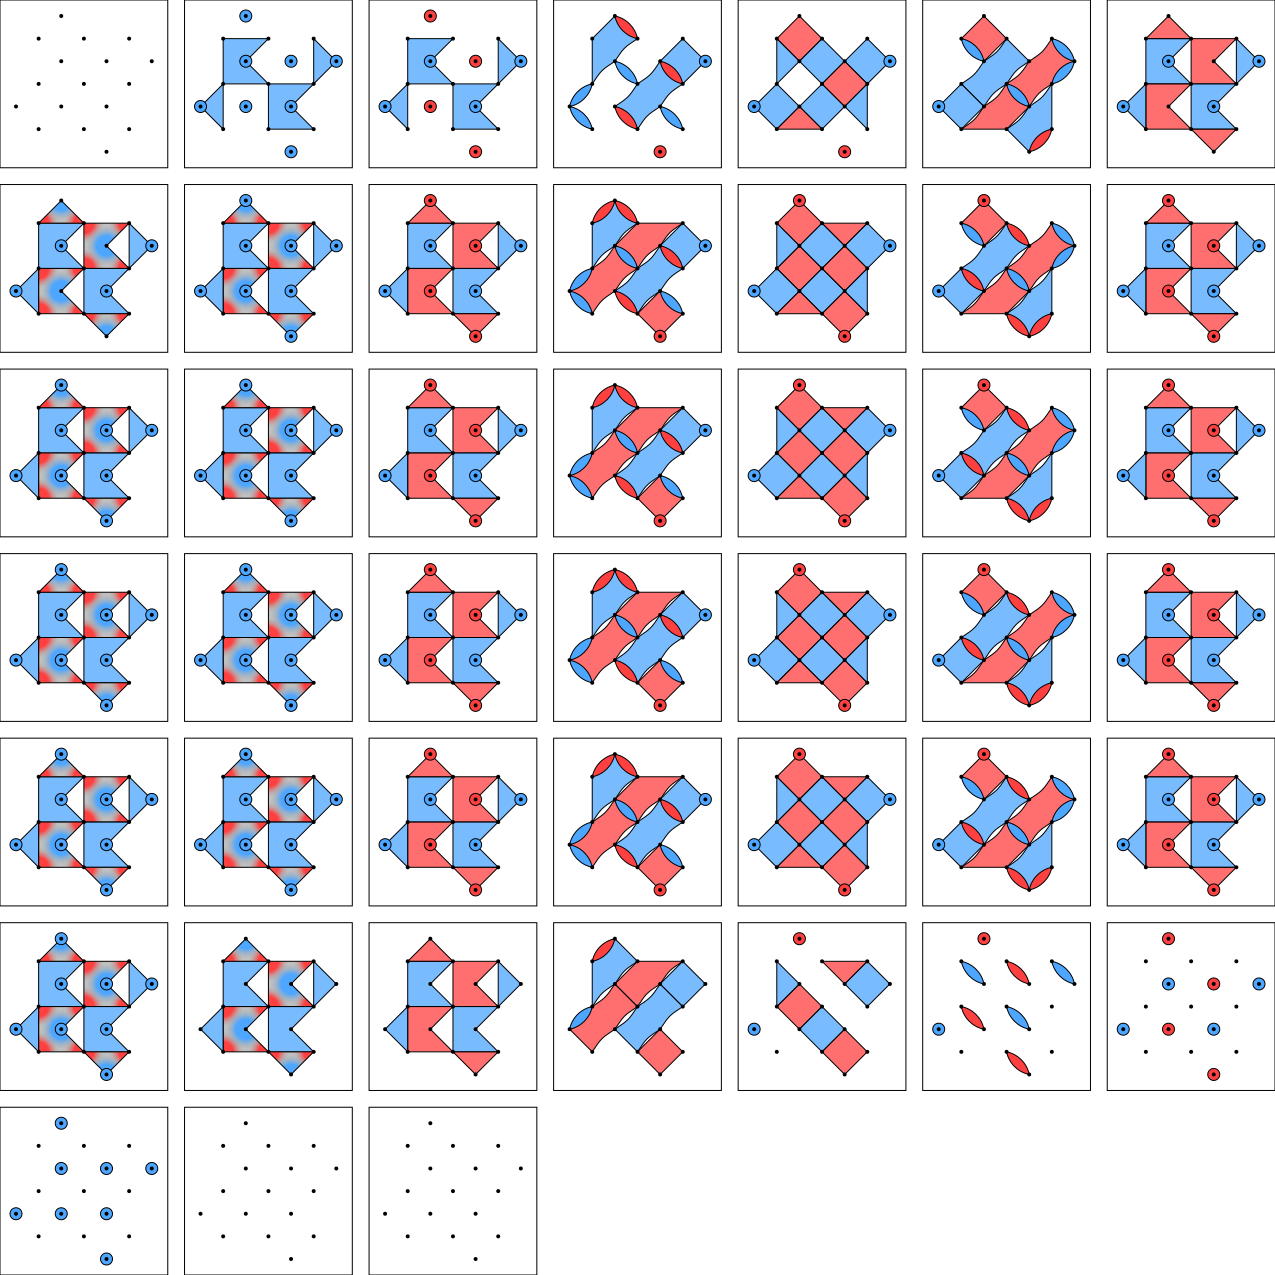

In [14]:
circuit.without_noise().diagram("detslice-svg")

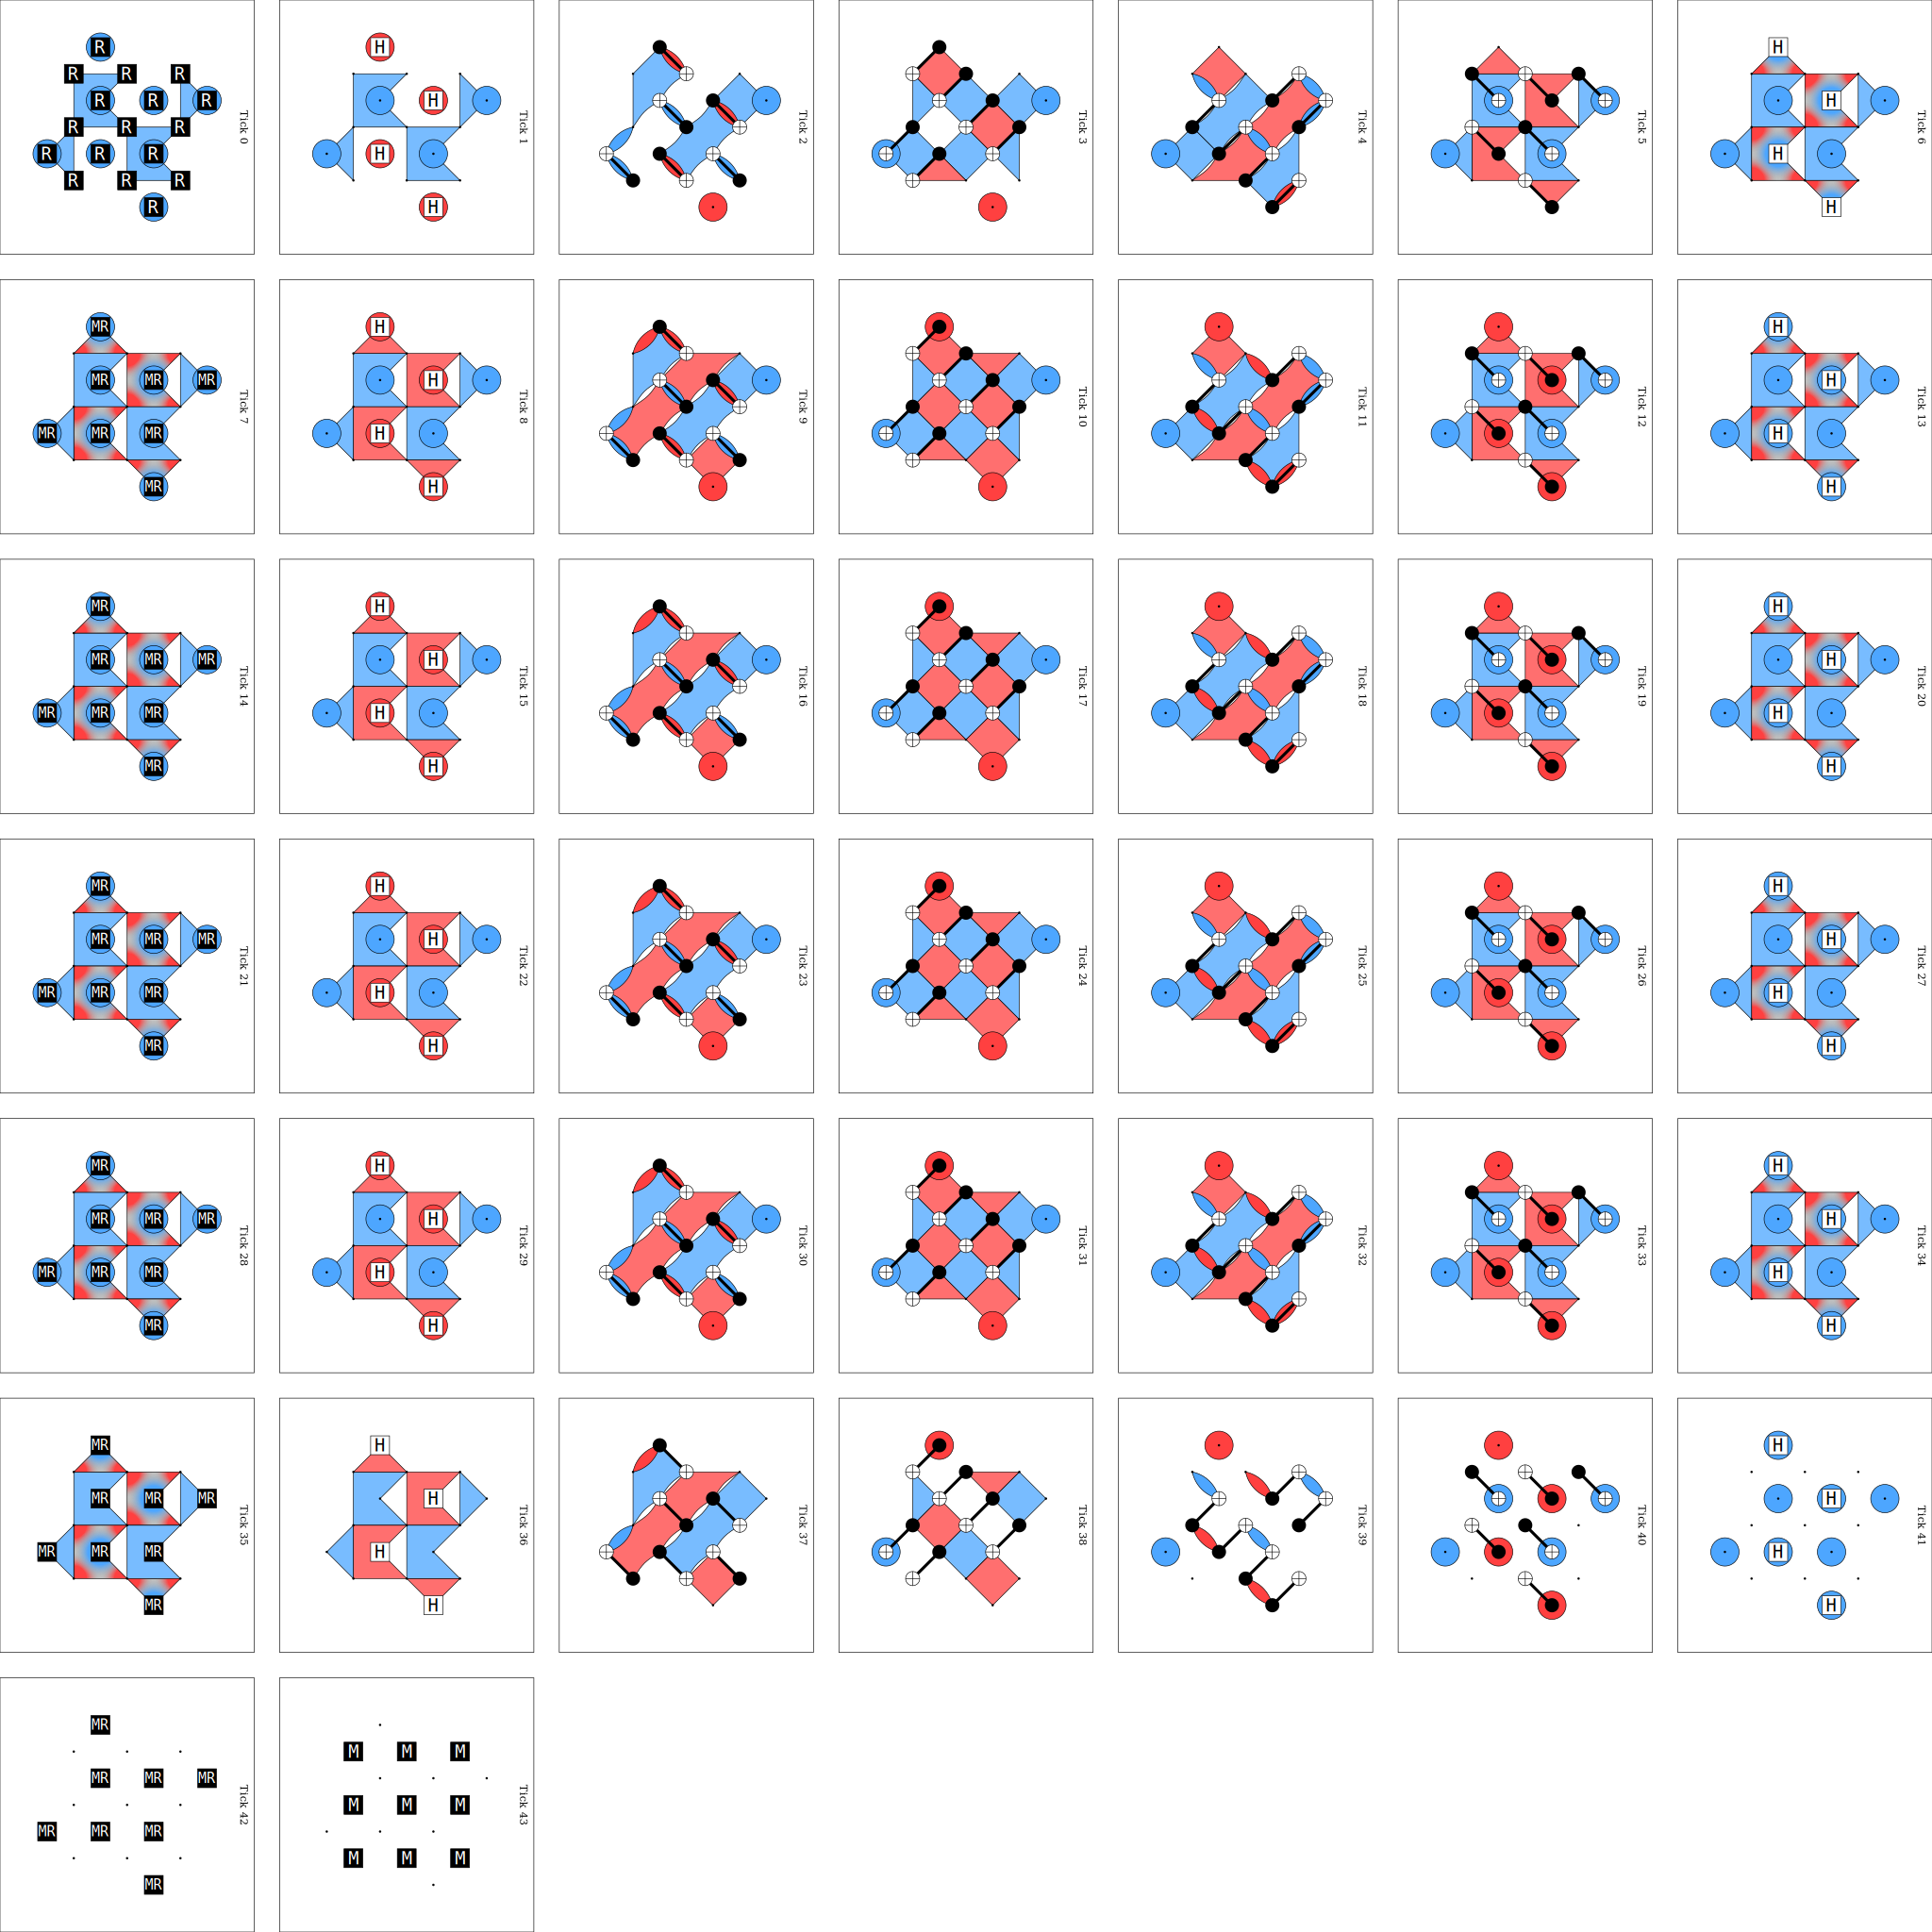

In [15]:
circuit.without_noise().diagram(
    "detslice-with-ops-svg", 
    tick=range(0, 100),
)

In [16]:

def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [17]:
num_shots = 100_000
num_logical_errors = count_logical_errors(circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 0 wrong predictions (logical errors) out of 100000 shots
